In [3]:
import pandas as pd
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

## 0. predicted mbps data

In [4]:
species = ['human', 'worm', 'yeast', 'zebrafish']
pred_file_path = "../"
anno_file_path = "~/database/uniprot/swiss/metal_anno"
swiss_file_path = "~/database/uniprot/swiss"
fasta_file_path = "~/database/uniprot/fasta"

pred_mbps = []
pred_seqs = []
for i in species:
    df_pred = pd.read_table(os.path.join(pred_file_path, f"{i}_pred_mbps.tsv"))
    pred_uniprots = set(df_pred['seq_id'])
    for j in pred_uniprots:
        pred_mbps.append({'species': i, "uniprot": j})
        
    fasta_file = os.path.expanduser(os.path.join(fasta_file_path, f"{i}_for_msa.fasta"))
    for j in SeqIO.parse(fasta_file, "fasta"):
        uniprot = j.id
        if uniprot in pred_uniprots:
            pred_seqs.append(SeqRecord(seq=j.seq, id=uniprot, description=""))
SeqIO.write(pred_seqs, "./tmp/pred_mbps.fasta", "fasta")
df_pred = pd.DataFrame(pred_mbps)
df_pred.describe()

15645

,species,uniprot
count,15645,15645
unique,4,15645
top,zebrafish,A0A8M1RFD5
freq,6358,1


## 1. structural evidence part

### 1.1 collect mbps from pdb (using new conditions, see "./pred_evidence.sh")

### 1.2 annotate pdb polymer at resi level 

In [3]:
df = pd.read_table("~/database/pdb/rcsb_20230430/polymer_id_to_chain_ids.tsv")
chain_to_polymer = dict()
for _, row in df.iterrows():
    pdb = row['pdb']
    polymer_id = row['polymer_id']
    chain_ids = eval(row['chain_ids'])
    for i in chain_ids:
        chain_to_polymer[(pdb, i)] = (pdb, polymer_id)

# annotation        
df = pd.read_table("./tmp/exp_metal_sites.tsv", keep_default_na=False)
metal_sites = []
for site, df_site in df.groupby(['pdb', 'metal_chain', 'metal_pdb_seq_num', 'metal_resi']):
    pdb, metal_resi = site[0], site[-1]
    for _, row in df_site.iterrows():
        resi = row['resi']
        resi_chain = row['resi_chain']
        resi_ndb_seq_can_num = row['resi_ndb_seq_can_num']
        _, resi_polymer = chain_to_polymer[(pdb, resi_chain)]
        metal_sites.append({ # binding residues in all chains
            "pdb": pdb,
            "metal_resi": metal_resi,
            "resi": resi,
            "resi_polymer": resi_polymer,
            "resi_ndb_seq_can_num": resi_ndb_seq_can_num,
        })
df_metal_sites = pd.DataFrame(metal_sites)
df_metal_sites.drop_duplicates(inplace=True)
df_metal_sites.to_csv("./tmp/exp_metal_polymers.tsv", sep="\t", index=None)

# seq fasta
metal_polymers = set(zip(df_metal_sites['pdb'], df_metal_sites['resi_polymer']))
added_polymers = set()
seqs = []
for i in SeqIO.parse("./tmp/exp_mbps.fasta", "fasta"):
    pdb, chain = i.id.split("_")
    pdb, polymer = chain_to_polymer[(pdb, chain)]
    if (pdb, polymer) in metal_polymers and (pdb, polymer) not in added_polymers:
        added_polymers.add((pdb, polymer))
        seqs.append(SeqRecord(seq=i.seq, id="_".join([pdb, str(polymer)]), description=""))
assert added_polymers == metal_polymers
SeqIO.write(seqs, "./tmp/exp_metal_polymers.fasta", "fasta")

76703

### 1.3 prepare blast db for blastp, see "./pred_evidence.sh"

### 1.4 use blastp to search homo metal polymers, see "./pred_evidence.sh"

### 1.5 align seq and select the corresponding pdb structure with the most aligned metal residue

In [5]:
from Bio.SeqUtils import seq1
uniprot_to_residues = dict()
for i in species:
    df_pred_sp = pd.read_table(f"../{i}_pred_mbps.tsv")
    for _, row in df_pred_sp.iterrows():
        resi_1, resi_seq_posi_1 = row['resi_1'], row['resi_seq_posi_1']
        resi_2, resi_seq_posi_2 = row['resi_2'], row['resi_seq_posi_2']
        seq_id = row['seq_id']
        if seq_id not in uniprot_to_residues.keys():
            uniprot_to_residues[seq_id] = set([(resi_1, resi_seq_posi_1 + 1), (resi_2, resi_seq_posi_2 + 1)])
        else:
            uniprot_to_residues[seq_id].add((resi_1, resi_seq_posi_1 + 1))
            uniprot_to_residues[seq_id].add((resi_2, resi_seq_posi_2 + 1))
            
polymers_to_residues = dict()
df_anno = pd.read_table("./tmp/exp_metal_polymers.tsv")
for anno_uniprot, df in df_anno.groupby(['pdb', 'resi_polymer']):
    pdb, polymer = anno_uniprot
    id = "_".join([pdb, str(polymer)])
    residues = set()
    for _, row in df.iterrows():
        residues.add((seq1(row['resi']), row['resi_ndb_seq_can_num']))
    polymers_to_residues[id] = residues

uniprot_to_seq = dict()
for i in SeqIO.parse("./tmp/pred_mbps.fasta", "fasta"):
    uniprot_to_seq[i.id] = str(i.seq)

polymer_to_seq = dict()
for i in SeqIO.parse("./tmp/exp_metal_polymers.fasta", "fasta"):
    polymer_to_seq[i.id] = str(i.seq)


In [3]:
df_blast = pd.read_table("./tmp/pred_mbps_exp.blast", header=None)
df_blast.rename(columns={0: "uniprot", 1: "pdb", 10: "evalue", 11: "bitscore"}, inplace=True)
df_blast.head()

,uniprot,pdb,2,3,4,5,6,7,8,9,evalue,bitscore
0,Q9UIX4,7ukh_1,33.867,437,236,12,58,483,31,425,6.530000e-70,233.0
1,Q9UIX4,7f0j_1,33.867,437,236,12,58,483,31,425,8.120000e-69,233.0
2,Q9UIX4,7phh_1,32.618,466,229,11,60,467,5,443,5.410000e-64,217.0
3,Q9UIX4,7phk_1,32.618,466,229,11,60,467,5,443,5.410000e-64,217.0
4,Q9UIX4,7phl_1,32.618,466,229,11,60,467,5,443,5.410000e-64,217.0


In [8]:
import sys
sys.path.append(f"{PROJECT_DIR}/dataset/collect/scripts/utils/")
from mmcif_utils import align_two_seq

ched = {'C', 'H', 'E', 'D'}
def collect_matched_residues(uniprot, pdb_polymer):
    uni_seq = uniprot_to_seq[uniprot]
    poly_seq = polymer_to_seq[pdb_polymer]
    
    uni_residues = uniprot_to_residues[uniprot]
    poly_residues = polymers_to_residues[pdb_polymer]
    
    align_dict = align_two_seq(uni_seq, poly_seq)
    metal_matched_dict = dict()
    for uni_resi, uni_seq_num in uni_residues:
        uni_seq_posi = uni_seq_num - 1
        if uni_seq_posi in align_dict.keys():
            poly_seq_num = align_dict[uni_seq_posi] + 1
            for r in ched:
                if (r, poly_seq_num) in poly_residues:
                    metal_matched_dict[(uni_resi, uni_seq_num)] = (r, poly_seq_num)
                    break
    return metal_matched_dict

records = []
for uniprot, df in df_blast.groupby(['uniprot']):
    cur_matched = dict()
    df_ = df.sort_values(by=['bitscore'], ascending=False)
    for _, row in df_.iterrows():
        anno_uniprot = row['pdb']
        evalue = row['evalue']
        result = collect_matched_residues(uniprot, anno_uniprot)
        if len(result.keys()) != 0:
            if "mapper" not in cur_matched.keys():
                cur_matched['polymer'] = anno_uniprot
                cur_matched['mapper'] = result
                cur_matched['evalue'] = evalue
            else:
                if len(result.keys()) > len(cur_matched['mapper'].keys()):
                    cur_matched['polymer'] = anno_uniprot
                    cur_matched['mapper'] = result
                    cur_matched['evalue'] = evalue
    if "polymer" in cur_matched.keys():
        records.append({
            "uniprot": uniprot,
            "pdb_polymer": cur_matched['polymer'],
            "evalue": cur_matched['evalue'],
            "mapper": cur_matched['mapper']
        })
pd.DataFrame(records).to_csv("pred_mbps_structural_evidence.tsv", sep="\t", index=None)

In [9]:
df = pd.read_table("pred_mbps_structural_evidence.tsv")
print(len(df))
print(len(df[df['mapper'].map(lambda x: len(eval(x)) > 1)]))

10129
9691


## 2. annotation evidence

### 2.1 get seqs for proteins that have annotation evidence

In [11]:
anno_uniprots = set(pd.read_table(os.path.join(anno_file_path, "uniprot_sprot_metal_anno.tsv"))['uniprot'])
seqs = []
for r in SeqIO.parse(os.path.expanduser(os.path.join(swiss_file_path, "uniprot_sprot.dat")), "swiss"):
    if r.id in anno_uniprots:
        seqs.append(SeqRecord(seq=r.seq, id=r.id, description=""))
SeqIO.write(seqs, "./tmp/anno_metal_uniprots.fasta", "fasta")

/tmp/ipykernel_13511/339944797.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  anno_uniprots = set(pd.read_table(os.path.join(anno_file_path, "uniprot_sprot_metal_anno.tsv"))['uniprot'])


91048

### 2.2 prepare blast db for blastp, see"./pred_evidence.sh"

### 2.3 use blastp to search homo metal polymers, see "./pred_evidence.sh"

### 2.4 align seq and select the corresponding pdb structure with the most aligned metal residue

In [10]:
uniprot_to_residues = dict()
for i in species:
    df_pred_sp = pd.read_table(f"../{i}_pred_mbps.tsv")
    for _, row in df_pred_sp.iterrows():
        resi_1, resi_seq_posi_1 = row['resi_1'], row['resi_seq_posi_1']
        resi_2, resi_seq_posi_2 = row['resi_2'], row['resi_seq_posi_2']
        seq_id = row['seq_id']
        if seq_id not in uniprot_to_residues.keys():
            uniprot_to_residues[seq_id] = set([(resi_1, resi_seq_posi_1 + 1), (resi_2, resi_seq_posi_2 + 1)])
        else:
            uniprot_to_residues[seq_id].add((resi_1, resi_seq_posi_1 + 1))
            uniprot_to_residues[seq_id].add((resi_2, resi_seq_posi_2 + 1))
            
anno_uniprot_to_residues = dict()
df_anno = pd.read_table(os.path.join(anno_file_path, "uniprot_sprot_metal_anno.tsv"))
for uniprot, df in df_anno.groupby(['uniprot']):
    residues = set(zip(df['resi'], df['resi_seq_num']))
    anno_uniprot_to_residues[uniprot] = residues

uniprot_to_seq = dict()
for i in SeqIO.parse("./tmp/pred_mbps.fasta", "fasta"):
    uniprot_to_seq[i.id] = str(i.seq)

anno_uniprot_to_seq = dict()
for i in SeqIO.parse("./tmp/anno_metal_uniprots.fasta", "fasta"):
    anno_uniprot_to_seq[i.id] = str(i.seq)

/tmp/ipykernel_6356/556188348.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anno = pd.read_table(os.path.join(anno_file_path, "uniprot_sprot_metal_anno.tsv"))


In [11]:
df_blast = pd.read_table("./tmp/pred_mbps_anno.blast", header=None)
df_blast.rename(columns={0: "uniprot", 1: "anno_uniprot", 10: "evalue", 11: "bitscore"}, inplace=True)
df_blast.head()

,uniprot,anno_uniprot,2,3,4,5,6,7,8,9,evalue,bitscore
0,Q9UIX4,Q9NSA2,34.130,460,259,9,28,483,8,427,5.050000e-73,245.0
1,Q9UIX4,Q03719,34.988,423,234,9,65,483,42,427,1.680000e-71,241.0
2,Q9UIX4,Q52PG9,33.696,460,261,10,28,483,8,427,1.320000e-69,236.0
3,Q9UIX4,Q9NZV8,33.867,437,236,12,58,483,31,425,1.250000e-68,233.0
4,Q9UIX4,Q9Z0V2,33.867,437,236,12,58,483,31,425,1.570000e-68,233.0


In [12]:
ched = {'C', 'H', 'E', 'D'}
def collect_matched_residues(uniprot, pdb_polymer):
    uni_seq = uniprot_to_seq[uniprot]
    anno_uni_seq = anno_uniprot_to_seq[pdb_polymer]
    
    uni_residues = uniprot_to_residues[uniprot]
    anno_uni_residues = anno_uniprot_to_residues[pdb_polymer]
    
    align_dict = align_two_seq(uni_seq, anno_uni_seq)
    metal_matched_dict = dict()
    for uni_resi, uni_seq_num in uni_residues:
        uni_seq_posi = uni_seq_num - 1
        if uni_seq_posi in align_dict.keys():
            anno_uni_seq_num = align_dict[uni_seq_posi] + 1
            for r in ched:
                if (r, anno_uni_seq_num) in anno_uni_residues:
                    metal_matched_dict[(uni_resi, uni_seq_num)] = (r, anno_uni_seq_num)
                    break
    return metal_matched_dict

records = []
for uniprot, df in df_blast.groupby(['uniprot']):
    cur_matched = dict()
    df_ = df.sort_values(by=['bitscore'], ascending=False)
    for _, row in df_.iterrows():
        anno_uniprot = row['anno_uniprot']
        evalue = row['evalue']
        result = collect_matched_residues(uniprot, anno_uniprot)
        if len(result.keys()) != 0:
            if "mapper" not in cur_matched.keys():
                cur_matched['anno_uniprot'] = anno_uniprot
                cur_matched['mapper'] = result
                cur_matched['evalue'] = evalue
            else:
                if len(result.keys()) > len(cur_matched['mapper'].keys()):
                    cur_matched['anno_uniprot'] = anno_uniprot
                    cur_matched['mapper'] = result
                    cur_matched['evalue'] = evalue
    if "anno_uniprot" in cur_matched.keys():
        records.append({
            "uniprot": uniprot,
            "anno_uniprot": cur_matched['anno_uniprot'],
            "evalue": cur_matched['evalue'],
            "mapper": cur_matched['mapper']
        })
pd.DataFrame(records).to_csv("pred_mbps_annotation_evidence.tsv", sep="\t", index=None)

## 3. analyze and visualize

In [5]:
struct_evid = pd.read_table("pred_mbps_structural_evidence.tsv")
anno_evid = pd.read_table("pred_mbps_annotation_evidence.tsv")
uni_with_struct_evid = set(struct_evid['uniprot'])
uni_with_anno_evid = set(anno_evid['uniprot'])
intersection = uni_with_anno_evid & uni_with_struct_evid
no_evid = set(df_pred['uniprot']) - uni_with_struct_evid - (uni_with_anno_evid - intersection)

data = {
    "structural evidence": len(uni_with_struct_evid),
    "indirect evidence": len(uni_with_anno_evid - intersection),
    "unannotated": len(no_evid)
}
y = data.values()
x = data.keys()
print(data)

{'structural evidence': 10129, 'indirect evidence': 495, 'unannotated': 5021}


In [6]:
dfs = []
for i in species:
    df = pd.read_table(f"../{i}_pred_mbps.tsv")
    df = df[df['seq_id'].map(lambda x: x in no_evid)]
    df = df.drop(columns=['index'])
    df['species'] = i
    dfs.append(df)
pd.concat(dfs).to_csv("no_evidence_pred_mbps.tsv", sep="\t", index=None)

Text(0.5, -0.1, 'Total number of predicted\n proteins = 15645')

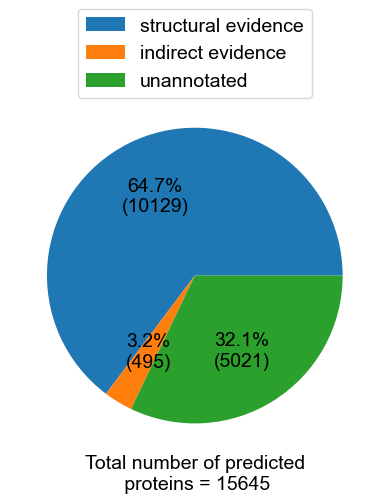

In [8]:
import matplotlib.pyplot as plt
plt.style.use(f"{PROJECT_DIR}/asset/metalnet.mplstyle")

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

patches= plt.pie(
    y,
    radius=1,
    autopct=make_autopct(y),
)
plt.legend(
    x, 
    bbox_to_anchor=(0.5, 1.1), 
    loc='center', 
)
plt.title(
    f"Total number of predicted\n proteins = {sum(y)}",
    loc="center",
    y=-0.1,
    fontsize=14
)
plt.savefig("./fig/ratio_metalloproteome_evidence.pdf", bbox_inches="tight", transparent=True)